## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

# Testing a Constrained Model for Discrimination and Remediating Discovered Discrimination

Fairness is a difficult and complex topic. So much so that leading scholars have yet to agree on a strict definition. However, there is a practical way to discuss and handle observational fairness, or how your model predictions affect different groups of people. This procedure is often known as disparate impact analysis (DIA). This example DIA notebook starts by loading a pre-trained constrained, monotonic gradient boosting machine (GBM) classifier. A probability cutoff for making credit decisions is selected by maximizing Youden's J statistic and confusion matrices are generated to summarize the GBM’s decisions across male and female customers. A basic DIA procedure is then conducted using the information stored in the confusion matrices and several traditional fair lending measures are also calculated.

Because DIA only considers groups of people, it's also important to look for any local, or individual, discrimination that would not be flagged in the group fairness quantities. This notebook closes by illustrating a basic search for cases of individual discrimination.

#### Global hyperpameters

In [1]:
SEED = 12345 # global random seed for better reproducibility

#### Python imports and inits

In [2]:
from rmltk import debug, evaluate, model # simple module for evaluating, debugging, and training models

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator # for GBM

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# display plots in-notebook
%matplotlib inline   

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_252"; OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09); OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
  Starting server from /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwbigsuw9
  JVM stdout: /tmp/tmpwbigsuw9/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpwbigsuw9/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,9 months and 10 days !!!
H2O cluster name:,H2O_from_python_patrickh_8fev5r
H2O cluster total nodes:,1
H2O cluster free memory:,1.879 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


## 1. Download, Explore, and Prepare UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

Demographic variables will not be used as model inputs as is common in credit scoring models. However, demographic variables will be used after model training to test for disparate impact.

#### Import data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y_name = 'DEFAULT_NEXT_MONTH'
x_names = [name for name in data.columns if name not in [y_name, 'ID', 'AGE', 'EDUCATION', 'MARRIAGE', 'SEX']]
print('y =', y_name)
print('X =', x_names)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset.

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    
    # recode values using apply() and lambda function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i])           
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Split data into training and validation partitions
Fairness metrics will be calculated for the validation data to give a better idea of how explanations will look on future unseen data.

In [6]:
# split into training and validation
train, valid = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 21060, columns = 25
Validation data rows = 8940, columns = 25


## 2. Load Pre-trained Monotonic GBM
Load the model known as `mgbm5` from the first lecture.

In [7]:
# load saved best model from lecture 1 
best_mgbm = h2o.load_model('best_mgbm')

# display model details
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  best_mgbm


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,6939.0,3.0,3.0,3.0,5.0,8.0,7.369565




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13637719864300343
RMSE: 0.3692928358945018
LogLoss: 0.4351274080189972
Mean Per-Class Error: 0.2913939696264273
AUC: 0.7716491282246187
pr_auc: 0.5471826859054356
Gini: 0.5432982564492375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21968260039166268: 

,,0,1,Error,Rate
0,0,13482.0,2814.0,0.1727,(2814.0/16296.0)
1,1,1907.0,2743.0,0.4101,(1907.0/4650.0)
2,Total,15389.0,5557.0,0.2254,(4721.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219683,0.537474,248.0
1,max f2,0.127859,0.630227,329.0
2,max f0point5,0.446699,0.583033,147.0
3,max accuracy,0.446699,0.821493,147.0
4,max precision,0.950247,1.000000,0.0
5,max recall,0.050609,1.000000,395.0
6,max specificity,0.950247,1.000000,0.0
7,max absolute_mcc,0.325159,0.413494,194.0
8,max min_per_class_accuracy,0.177542,0.698495,281.0
9,max mean_per_class_accuracy,0.219683,0.708606,248.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010074,0.813927,3.607883,3.607883,0.800948,0.843446,0.800948,0.843446,0.036344,0.036344,260.788259,260.788259
1,,2,0.020338,0.795575,3.519808,3.563432,0.781395,0.805153,0.791080,0.824119,0.036129,0.072473,251.980795,256.343177
2,,3,0.030316,0.763679,3.405328,3.511394,0.755981,0.783970,0.779528,0.810905,0.033978,0.106452,240.532798,251.139446
3,,4,0.040008,0.715138,3.261891,3.450954,0.724138,0.739815,0.766110,0.793684,0.031613,0.138065,226.189099,245.095388
4,,5,0.050081,0.664416,3.116869,3.383755,0.691943,0.686695,0.751192,0.772164,0.031398,0.169462,211.686898,238.375473
5,,6,0.100019,0.543384,2.859463,3.121984,0.634799,0.601794,0.693079,0.687101,0.142796,0.312258,185.946339,212.198445
6,,7,0.150005,0.366237,2.224293,2.822849,0.493792,0.446951,0.626671,0.607076,0.111183,0.423441,122.429306,182.284922
7,,8,0.205672,0.292765,1.595510,2.490659,0.354202,0.312777,0.552925,0.527422,0.088817,0.512258,59.551043,149.065864
8,,9,0.301251,0.196648,1.174504,2.073077,0.260739,0.234499,0.460222,0.434485,0.112258,0.624516,17.450421,107.307684
9,,10,0.400029,0.173817,0.864327,1.774604,0.191880,0.184844,0.393961,0.372842,0.085376,0.709892,-13.567284,77.460410




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13326994104124376
RMSE: 0.3650615578792757
LogLoss: 0.4278285715046422
Mean Per-Class Error: 0.2856607030196092
AUC: 0.7776380047998697
pr_auc: 0.5486322626112021
Gini: 0.5552760095997393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27397344199105433: 

,,0,1,Error,Rate
0,0,6093.0,975.0,0.1379,(975.0/7068.0)
1,1,863.0,1123.0,0.4345,(863.0/1986.0)
2,Total,6956.0,2098.0,0.203,(1838.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273973,0.549951,217.0
1,max f2,0.147835,0.634488,307.0
2,max f0point5,0.436620,0.590736,153.0
3,max accuracy,0.456963,0.825271,147.0
4,max precision,0.947069,1.000000,0.0
5,max recall,0.045106,1.000000,397.0
6,max specificity,0.947069,1.000000,0.0
7,max absolute_mcc,0.347246,0.429999,184.0
8,max min_per_class_accuracy,0.181585,0.709970,275.0
9,max mean_per_class_accuracy,0.230518,0.714339,240.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011155,0.815010,3.295055,3.295055,0.722772,0.839858,0.722772,0.839858,0.036757,0.036757,229.505549,229.505549
1,,2,0.020543,0.795575,3.700764,3.480460,0.811765,0.805631,0.763441,0.824217,0.034743,0.071501,270.076417,248.045999
2,,3,0.030042,0.783550,3.604721,3.519749,0.790698,0.792441,0.772059,0.814170,0.034240,0.105740,260.472142,251.974853
3,,4,0.040093,0.743192,3.005876,3.390927,0.659341,0.761335,0.743802,0.800925,0.030211,0.135952,200.587630,239.092657
4,,5,0.050033,0.697702,3.444512,3.401573,0.755556,0.723091,0.746137,0.785461,0.034240,0.170191,244.451158,240.157260
5,,6,0.101281,0.553193,3.104777,3.251394,0.681034,0.614736,0.713195,0.699075,0.159114,0.329305,210.477654,225.139444
6,,7,0.150320,0.383564,2.187046,2.904171,0.479730,0.466067,0.637032,0.623061,0.107251,0.436556,118.704581,190.417123
7,,8,0.200022,0.296915,1.580423,2.575244,0.346667,0.327817,0.564881,0.549698,0.078550,0.515106,58.042296,157.524427
8,,9,0.301303,0.203539,1.133514,2.090616,0.248637,0.250648,0.458578,0.449174,0.114804,0.629909,13.351366,109.061561
9,,10,0.403468,0.176970,0.961068,1.804595,0.210811,0.187190,0.395839,0.382836,0.098187,0.728097,-3.893198,80.459549




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-05-28 14:33:23,43.415 sec,0.0,0.415591,0.529427,0.500000,0.000000,1.000000,0.778001,0.413815,0.526105,0.500000,0.000000,1.000000,0.780649
1,,2020-05-28 14:33:23,43.443 sec,1.0,0.407822,0.511864,0.716131,0.534717,3.474912,0.236370,0.405538,0.507496,0.726731,0.537125,3.444264,0.187652
2,,2020-05-28 14:33:23,43.467 sec,2.0,0.401483,0.498746,0.744646,0.532172,3.529706,0.228731,0.398808,0.493698,0.752909,0.534588,3.422307,0.232825
3,,2020-05-28 14:33:23,43.489 sec,3.0,0.396471,0.489013,0.748189,0.535621,3.529706,0.228636,0.393394,0.483273,0.756448,0.535692,3.422307,0.214491
4,,2020-05-28 14:33:23,43.515 sec,4.0,0.392442,0.481430,0.750121,0.535358,3.529706,0.210780,0.389030,0.475135,0.758511,0.536095,3.422307,0.217915
5,,2020-05-28 14:33:23,43.535 sec,5.0,0.389141,0.475375,0.750058,0.535198,3.529706,0.245059,0.385453,0.468630,0.758505,0.535659,3.422307,0.214270
6,,2020-05-28 14:33:23,43.570 sec,6.0,0.386399,0.470332,0.756986,0.535024,3.529706,0.243961,0.382447,0.463157,0.764722,0.536039,3.422307,0.229843
7,,2020-05-28 14:33:23,43.592 sec,7.0,0.384191,0.466316,0.757005,0.535418,3.529706,0.243961,0.380045,0.458834,0.764634,0.536411,3.422307,0.220013
8,,2020-05-28 14:33:23,43.614 sec,8.0,0.382341,0.462760,0.761106,0.540176,3.514359,0.247446,0.378063,0.455049,0.770340,0.542043,3.457524,0.204330
9,,2020-05-28 14:33:23,43.639 sec,9.0,0.380701,0.459589,0.762515,0.540880,3.518279,0.235654,0.376184,0.451464,0.772358,0.543522,3.457524,0.223548



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,PAY_0,2794.444824,1.000000,0.693347
1,PAY_2,307.237366,0.109946,0.076231
2,PAY_3,215.152893,0.076993,0.053383
3,PAY_4,155.434448,0.055623,0.038566
4,PAY_AMT1,127.986313,0.045800,0.031755
5,PAY_5,127.538628,0.045640,0.031644
6,PAY_6,102.351601,0.036627,0.025395
7,LIMIT_BAL,82.432350,0.029499,0.020453
8,PAY_AMT2,58.934135,0.021090,0.014623
9,PAY_AMT4,58.858047,0.021063,0.014604


## 3. Select a Probability Cutoff by Maximizing Youden's J Statistic

#### Bind model predictions to test data for further calculations

In [8]:
# cbind predictions to training frame
# give them a nice name
yhat_name = 'p_DEFAULT_NEXT_MONTH'
preds1 = valid['ID'].cbind(best_mgbm.predict(valid).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat_name]
valid_yhat = valid.cbind(preds1[yhat_name]).as_data_frame()
valid_yhat.reset_index(drop=True, inplace=True) # necessary for later searches/joins

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Select best cutoff based on Youden's J
Maximizing Youden's J statistic corresponds to selecting the cutoff where the AUC curve is the farthest from the baseline. This is appropriate for classifiers that were trained to maximize AUC. However, cutoff selection has a strong impact on group fairness measures. Other options for the cutoff are also presented below.

In [9]:
j_frame = evaluate.get_youdens_j(valid_yhat, y_name, yhat_name)
best_cut = j_frame.loc[j_frame['J'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
### !!! UNCOMMENT LINES BELOW TO REMEDIATE MINOR FAIRNESS ISSUES !!! ###
#best_cut = 0.31 # lowest cutoff that passess discrimination tests
#best_cut = 0.456963 # max accuracy
#best_cut = 0.347246 # max MCC
print('%.2f' % best_cut)

0.22


#### Plot ROC Curve
An receiver operating characteristic (ROC) curve for true positive rate (TPR) and false negative rate (FNR) is a typical way to visualize TPR and FNR for a binomial predictive model. 

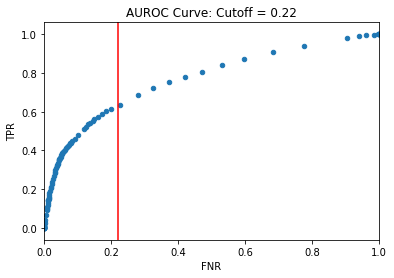

In [10]:
# Plot AUROC w/ best cutoff
title_ = 'AUROC Curve: Cutoff = ' + str(best_cut)
ax = j_frame.plot(x='FNR', y='TPR', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

## 4. Report Raw Confusion Matrices

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the GBM's behavior in general and across men and women.

#### Overall confusion matrix

In [11]:
evaluate.get_confusion_matrix(valid_yhat, y_name, yhat_name, cutoff=best_cut)

,actual: 1,actual: 0
predicted: 1,1179,1192
predicted: 0,824,5745


The general confusion matrix shows that the GBM is more accurate than not because the true positive and true negative cells contain the largest values by far. But the GBM seems to make a larger number of type II errors or false negative predictions. False negatives can be a disparity issue, because for complex reasons, many credit scoring and other models tend to over-estimate the likelihood of non-reference groups - typically people other than white males - to default. This is both a sociological discrimination problem and a financial problem if an unpriviledged group is not recieving the credit they deserve, in favor of undeserving white males. Deserving people miss out on potentially life-changing credit and lenders incur large write-off costs.

#### Report confusion matrices by `SEX`

The only values for `SEX` in the dataset are `female` and `male`. 

In [12]:
sex_levels = list(valid_yhat['SEX'].unique())
sex_levels

['female', 'male']

#### Confusion matrix for `SEX = male`

In [13]:
male_cm = evaluate.get_confusion_matrix(valid_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='SEX', level='male', cutoff=best_cut)
male_cm

,actual: 1,actual: 0
predicted: 1,511,482
predicted: 0,360,2124


#### Confusion matrix for `SEX = female`

In [14]:
female_cm = evaluate.get_confusion_matrix(valid_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='SEX', level='female', cutoff=best_cut)
female_cm

,actual: 1,actual: 0
predicted: 1,668,710
predicted: 0,464,3621


Both confusion matrices reflect the global confusion matrix: more accurate than not with a larger number of false negative predictions (type II errors) than false positive predictions (type I errors).

## 5. Disparate Accuracies and Errors

To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the GBM's overall performance and how it behaves when predicting:

* Default correctly
* Non-default correctly
* Default incorrectly (type I errors)
* Non-default incorrectly (type II errors)

In a real-life lending scenario, type I errors essentially amount to false accusations of financial impropriety and type II errors result in awarding loans to undeserving customers. Both types of errors can be costly to the lender too. Type I errors likely result in lost interest and fees. Type II errors often result in write-offs.

#### Calculate and report group fairness metrics

In [15]:
cm_dict = {'male': male_cm, 'female': female_cm} # group fairness metrics are based on confusion matrices
metrics_frame, disp_frame = debug.get_metrics_ratios(cm_dict, 'male') # calculate metrics and ratios
metrics_frame # display results

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
female,0.207212,0.785100,0.590106,0.484761,0.836066,0.886414,0.163934,0.515239,0.409894,0.113586
male,0.250503,0.757837,0.586682,0.514602,0.815042,0.855072,0.184958,0.485398,0.413318,0.144928


From eyeballing the raw metrics it appears that the model is treating men and women roughly similarly as groups. 

#### Plot false omissions rate by `SEX`

Because the confusion matrices indicated there might be a problem with non-default predictions, false omissions rate will be examined closely. False omissions measures how many customers the model predicted *incorrectly* would not default, out of the customers in the group the model *predicted* would not default. 

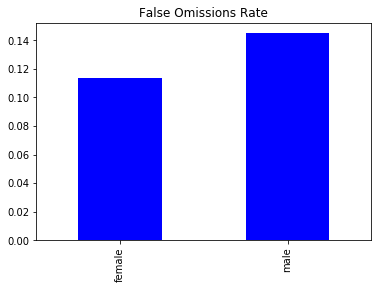

In [16]:
_ = metrics_frame['False Omissions Rate'].plot(kind='bar', color='b', title='False Omissions Rate')

#### Calculate and report disparity
To calculate disparity we compare the metrics to a user-defined reference level and to user-defined thresholds. In this case, we take the class of people who seem most priviledged as the reference level, i.e. `SEX = male`. (Usually the reference level would be `race = white` or `sex = male`.) According to the four-fifths rule (https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) thresholds are set such that metrics 20% lower or higher than the reference level metric will be flagged as disparate. **Technically, the four-fifths rule only applies to the adverse impact ratio, discussed further below, but it will be applied to all other displayed metrics here as a rule of thumb.**

In [17]:
parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value


# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Prevalence Ratio,Accuracy Ratio,True Positive Rate Ratio,Precision Ratio,Specificity Ratio,Negative Predicted Value Ratio,False Positive Rate Ratio,False Discovery Rate Ratio,False Negative Rate Ratio,False Omissions Rate Ratio
female,0.827183,1.03597,1.00584,0.94201,1.02579,1.03665,0.886334,1.06148,0.991716,0.783745
male,1,1,1,1,1,1,1,1,1,1


For the selected thresholds, the GBM appears to have only one value for metrics that is low out-of-range, false omissions rate. The flagged false omissions rate disparity indicates males may be receiving too many loans they cannot pay back, potentially preventing females from recieving these loans.

#### Plot false omissions rate disparity

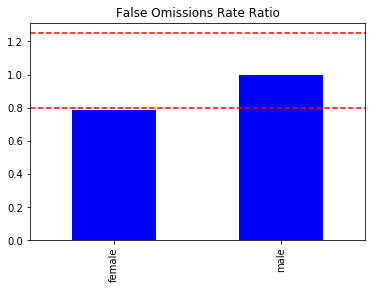

In [18]:
ax = disp_frame['False Omissions Rate Ratio'].plot(kind='bar', color='b', title='False Omissions Rate Ratio')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

The model is suffering from a minor disparity problem due to it's propensity to make false negative predictions for males. To address such discrimination, users could tune the GBM variables, cutoff or regularization, could try new methods for reweighing data prior to model training, try new modeling methods specifically designed for fairness, or post-process the decisions. Before attempting remediation here, more traditional fair lending measures will be assessed and, local, or individual, fairness will also be investigated. 

## 6. Traditional Fair Lending Measures

Along with adverse impact ratio (AIR), several measures have long-standing legal precedence in fair lending, including marginal effect and standardized mean difference. These measures are calculated and discussed here.

#### Calculate adverse impact ratio (AIR)
AIR is perhaps the most well-known discrimination measure. It was first delineated by the U.S. Equal Employment Opportunity Commission (EEOC) and AIR is associated with the convenient 4/5ths, or 0.8, cutoff threshold. AIR values below 0.8 can be considered evidence of illegal discrimination in many lending or employment scenarios in the U.S.

In [19]:
print('Adverse impact ratio: %.3f' % debug.air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.714
Female proportion accepted: 0.748
Adverse impact ratio: 1.047


Typical desirable ranges of AIR are above the 0.8 marker set by the 4/5ths rule. Here we see an almost ideal result where the protected and reference groups have very similar acceptance rates and AIR is near 1. 

#### Calculate marginal effect
Marginal effect describes the difference between the percent of the reference group awarded a loan and the percent of the protected group awarded a loan under a model. 

In [20]:
print('Marginal effect: %.2f%%' % debug.marginal_effect(cm_dict, 'male', 'female'))

Male accepted: 71.44%
Female accepted: 74.78%
Marginal effect: -3.33%


About 77% of men are awarded a loan by the model. About 79.6% of women are awarded a loan. This results in a marginal effect of -3.33%. Given that the marginal effect is negative, indicating that a higher percentage of individuals in the protected group were awarded a loan than in the reference group, this value would likely not indicate a discrimination problem in most scenarios. The magnitude of the marginal effect is also relatively small, another sign that discrimination concerning SEX is low under the model. Generally, larger marginal effects may be tolerated in newer credit products, whereas smaller marginal effects are expected in established credit products.

#### Calculate standardized mean difference
The standardized mean difference (SMD), i.e. Cohen's D, is the mean value of the prediction for the protected group minus the mean prediction for the reference group, all divided by the standard deviation of the prediction. Like AIR, SMD has some prescribed thresholds: 0.2, 0.5, and 0.8 for small, medium, and large differences, respectively. The standardized mean difference can also be used on continuous values like credit limits or loan amounts.

In [21]:
print('Standardized Mean Difference: %.2f' % debug.smd(valid_yhat, 'SEX', yhat_name, 'male', 'female'))

Male mean yhat: 0.23
Female mean yhat: 0.21
P_Default_Next_Month std. dev.:  0.18
Standardized Mean Difference: -0.08


For this model, in the validation set, men receive a higher average probability of default than do women. This difference is evident even after standardizing with the standard deviation of the predictions. However, the difference is quite small, below the 0.2 threshold for a small difference. SMD also points to low disparity between men and women under this model.

## 7. Investigate Individual Disparity 

Similar people can be treated differenly by the model, so even if the model is mostly fair for most kinds of people, there could still be people the model treated unfairly. This could occur for multiple reasons, including the functional form of the learned model or because different variables are combined by the model to represent strong signals. If a variable is important in a dataset, model, or problem domain it's likely that a nonlinear model will find combinations of other variables to act as proxies for the problematic variable -- potentially even different combinations for different rows of data! So by simply testing for group fairness, you may miss instances of individual discrimination.

#### Augment predictions with decisions and logloss residuals for women with false positive predictions
In this notebook, residuals for false positive predictions for women will be examined in an attempt to locate any individual instances of model discrimination. These are women who the model said would default, but they did not default. So they may have experienced some discrimination under the model.

In [22]:
valid_yhat_female = valid_yhat[valid_yhat['SEX'] == 'female'].copy(deep=True)


valid_yhat_female['d_DEFAULT_NEXT_MONTH'] = 0
valid_yhat_female.loc[valid_yhat_female[yhat_name] > best_cut, 'd_DEFAULT_NEXT_MONTH'] = 1

valid_yhat_female['r_DEFAULT_NEXT_MONTH'] = -valid_yhat_female[y_name]*np.log(valid_yhat_female[yhat_name]) -\
                       (1 - valid_yhat_female[y_name])*np.log(1 - valid_yhat_female[yhat_name]) 
    
valid_yhat_female_fp = valid_yhat_female[(valid_yhat_female[y_name] == 0) &\
                                         (valid_yhat_female['d_DEFAULT_NEXT_MONTH'] == 1)]

#### Plot logloss residuals
Residuals are a common way to visualize the errors of a model, and in just two dimensions.

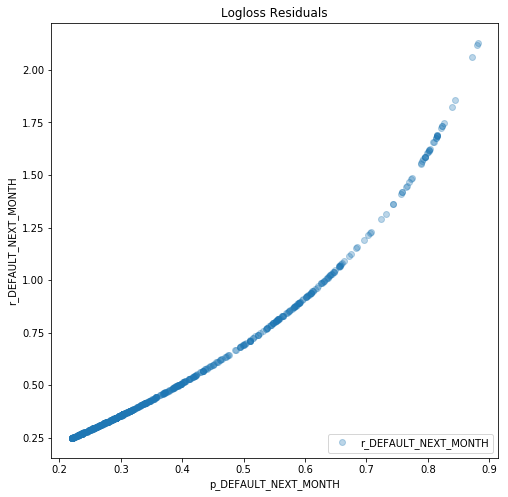

In [23]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

ax_.plot(valid_yhat_female_fp[yhat_name],
         valid_yhat_female_fp['r_DEFAULT_NEXT_MONTH'],
         marker='o', linestyle='', alpha=0.3)

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel('r_DEFAULT_NEXT_MONTH')
_ = ax_.legend(loc=4)
_ = plt.title('Logloss Residuals')

#### Examine low logloss residual individuals

Low residual individuals near the probability cutoff are some of the most likely to be treated differently from individuals who received the credit product. Those individuals are displayed below.

In [24]:
valid_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=True).head(n=150)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,d_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
5735,19327,230000,female,university,married,40,1,-2,-1,-1,-1,-1,0,0,3504,4272,2977,1900,0,3504,4272,2977,1900,0,0,0.220037,1,0.248509
7870,26436,160000,female,university,single,44,1,-2,-1,-1,-1,-1,-4,-4,3454,0,3312,0,0,3458,0,3312,0,0,0,0.220037,1,0.248509
3093,10387,20000,female,graduate school,single,29,-1,-1,-1,-1,-1,-1,342,792,677,-1,213,856,792,677,0,214,856,0,0,0.220296,1,0.248841
2821,9466,50000,female,university,married,34,0,0,2,0,0,0,11367,10982,10243,10826,11699,10146,3000,1000,1000,1000,2000,2000,0,0.220327,1,0.248881
151,501,30000,female,university,married,38,0,0,0,0,2,2,20344,21705,22537,24161,25128,24576,2000,1500,2000,1500,0,1200,0,0.220592,1,0.249220
6536,21992,150000,female,graduate school,single,29,-1,2,-1,-1,0,0,2599,1530,390,1366,780,0,0,390,1366,0,0,431,0,0.220832,1,0.249528
8244,27652,50000,female,graduate school,single,23,1,-1,-1,-2,-2,-2,-697,11361,0,0,0,0,12058,0,0,0,0,0,0,0.220909,1,0.249628
625,2058,50000,female,high school,married,51,0,0,2,0,0,0,44766,48047,46640,40551,19398,0,4000,0,811,1000,0,0,0,0.220939,1,0.249665
175,586,20000,female,graduate school,single,25,0,0,0,0,0,2,14603,15661,16394,16723,18056,17618,1600,1300,600,1600,0,800,0,0.220969,1,0.249705
7768,26079,210000,female,university,single,36,1,-2,-2,-2,-1,0,0,0,212,3066,13206,10583,0,212,3066,13206,212,0,0,0.221026,1,0.249778


Examining the low-residual false positives, it can be seen that the cutoff selected by Youden's J is a bit too conservative. Many women just above the cutoff have missed 0-2 payments, and only been late 1-2 months on the few payments they missed, if any. This potential discrimination problem can be remediated by increasing the cutoff in cell 9.

#### Simple adversarial de-biasing approach
Create a dataset with the protected variable and the predictions of the model.

In [25]:
adv_valid = h2o.H2OFrame(valid_yhat[['ID', 'SEX', yhat_name]])
adv_train, adv_valid = adv_valid.split_frame([0.7])
adv_train

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Train adversarial GBM
This adversarial GBM tries to predict whether a customer is a man or a woman just from the predictions of `best_mgbm`. The predictions of this adversarial model give a row-by-row measure for whether a prediction is encoding information about `SEX`.

In [26]:
adv_gbm = model.gbm_grid(yhat_name, 'SEX', adv_train, adv_valid, SEED)
print('Adversarial GBM AUC: %.2f' % adv_gbm.auc(valid=True))

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Adversarial GBM AUC: 0.51


Because the adversarial GBM cannot predict the `SEX` of the customer from the predictions of `best_mgbm`, this is a good sign that `best_mgbm` is not too discriminatory towards women.

#### Examine a few predictions from the adversarial GBM

In [33]:
valid_yhat['p_FEMALE_ADVERSARY'] = adv_gbm.predict(h2o.H2OFrame(valid_yhat))['female'].as_data_frame()
valid_yhat[(valid_yhat['SEX'] == 'female') & 
           (valid_yhat['p_FEMALE_ADVERSARY'] > 0.58) & 
           (valid_yhat[yhat_name] > best_cut)]\
    .sort_values(by=yhat_name)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,p_FEMALE_ADVERSARY
7870,26436,160000,female,university,single,44,1,-2,-1,-1,-1,-1,-4,-4,3454,0,3312,0,0,3458,0,3312,0,0,0,0.220037,0.591124
5735,19327,230000,female,university,married,40,1,-2,-1,-1,-1,-1,0,0,3504,4272,2977,1900,0,3504,4272,2977,1900,0,0,0.220037,0.591124
3093,10387,20000,female,graduate school,single,29,-1,-1,-1,-1,-1,-1,342,792,677,-1,213,856,792,677,0,214,856,0,0,0.220296,0.591124
2821,9466,50000,female,university,married,34,0,0,2,0,0,0,11367,10982,10243,10826,11699,10146,3000,1000,1000,1000,2000,2000,0,0.220327,0.591124
151,501,30000,female,university,married,38,0,0,0,0,2,2,20344,21705,22537,24161,25128,24576,2000,1500,2000,1500,0,1200,0,0.220592,0.591124
8558,28732,240000,female,university,married,35,-1,2,-1,-1,-1,-1,528,264,264,264,264,414,0,264,264,264,414,264,1,0.220832,0.591124
4571,15332,180000,female,graduate school,married,45,-1,2,-1,-1,-1,-1,1560,316,316,316,316,316,0,316,316,316,316,316,1,0.220832,0.591124
6536,21992,150000,female,graduate school,single,29,-1,2,-1,-1,0,0,2599,1530,390,1366,780,0,0,390,1366,0,0,431,0,0.220832,0.591124
8244,27652,50000,female,graduate school,single,23,1,-1,-1,-2,-2,-2,-697,11361,0,0,0,0,12058,0,0,0,0,0,0,0.220909,0.591124
3738,12517,50000,female,high school,single,50,0,0,2,0,0,0,47405,50138,25768,26142,26771,27175,4130,0,1100,1200,1000,1100,1,0.220939,0.591124


Some of the women in this set also appear to have missed only 0-2 payments, and been late only 1-2 months on the few payments they missed, if any.

#### Shutdown H2O

In [28]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? n
